In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import os
import numpy as np
import random
#To find the duration of wave file in seconds
import wave
import contextlib
#Keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

Using TensorFlow backend.


In [135]:
imheight = imwidth = 32
total_examples = 2000
speakers = 4
examples_per_speaker = 50
tt_split = 0.1
num_classes = 10

In [132]:
def find_spectrum(audio_file):
    fft_samples = 2048
    fs, samples = wavfile.read(audio_file) # load the data
    yf = fft(samples, n=fft_samples)
    yy = np.abs(yf[:fft_samples//2])
    return np.reshape(yy, (imheight, imwidth))

In [4]:
def normalize_gray(array):
    return (array - array.min())/(array.max() - array.min())

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [133]:
def create_train_test(audio_dir):
    file_names = [f for f in os.listdir(audio_dir) if '.wav' in f]
    file_names.sort()
    test_list = []
    train_list = []
    
    for i in range(int(total_examples/examples_per_speaker)):
        test_list.extend(random.sample(file_names[(i*examples_per_speaker+1):(i+1)*examples_per_speaker], int(examples_per_speaker*tt_split)))

    train_list = [x for x in file_names if x not in test_list]

    y_test = np.zeros(len(test_list))
    y_train = np.zeros(len(train_list))
    x_train = np.zeros((len(train_list), imheight, imwidth))
    x_test = np.zeros((len(test_list), imheight, imwidth))

    for i, f in enumerate(test_list):
        y_test[i] = int(f[0])
        x_test[i,:,:] = normalize_gray(find_spectrum(audio_dir + f))
        
    for i, f in enumerate(train_list):
        y_train[i] = int(f[0])
        x_train[i,:,:] = normalize_gray(find_spectrum(audio_dir + f))
        
    return x_train, y_train, x_test, y_test

In [136]:
x_train, y_train, x_test, y_test = create_train_test('./recordings/')

In [137]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [152]:
x_train = x_train.reshape(x_train.shape[0], imheight, imwidth, 1)
x_test = x_test.reshape(x_test.shape[0], imheight, imwidth, 1)
input_shape = (imheight, imwidth, 1)
batch_size = 100
epochs = 12

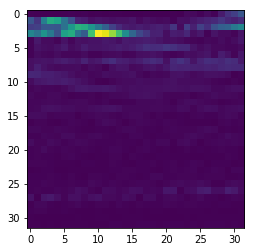

In [149]:
plt.imshow(x_train[500][:,:,0])

In [145]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [146]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])

In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [153]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 1800 samples, validate on 200 samples
Epoch 1/12
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0554 - acc: 0.9828 - val_loss: 0.3253 - val_acc: 0.9350
Epoch 2/12
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0676 - acc: 0.9744 - val_loss: 0.3235 - val_acc: 0.9400
Epoch 3/12
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0666 - acc: 0.9767 - val_loss: 0.3133 - val_acc: 0.9400
Epoch 4/12
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0545 - acc: 0.9800 - val_loss: 0.3058 - val_acc: 0.9300
Epoch 5/12
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0546 - acc: 0.9800 - val_loss: 0.3082 - val_acc: 0.9350
Epoch 6/12
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0533 - acc: 0.9811 - val_loss: 0.3170 - val_acc: 0.9250
Epoch 7/12
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0471 - acc: 0.9817 - val_loss: 0.3205 - val_acc: 0.9250
Epoch 8/